<h1 align='center'> Trabajo Práctico Especial. Señales y Sistemas </h1>
<h2 align='center'> Eliminación automática de ruidos tipo click </h2>
<h2 align='center'> Primer cuatrimestre 2023 </h2>
<h4 align='center'> Sebastián Mosquera </h4>

<h3 align='center'> Objetivo </h3>
<br>
<div align="justify">
La limpieza de señales de audio es una de la aplicaciones más populares del procesamiento digital de señales. <br>
Este trabajo se enfoca particularmente en señales de audio corruptas con ruidos tipo "click". Un "click" o "fritura" es una alteración de la señal, que en el tiempo se puede observar como un impulso, y que su espectro contiene energía en todas las frecuencias. Este hecho hace que no sea posible remover el "click" mediante simplemente un filtrado, se requiere además un procesamiento en el dominio del tiempo. <br> <br>
Veremos en este trabajo que este procesamiento consiste de 3 etapas fundamentales: Detección de los clicks, Generación de una nueva porción de señal, y Reemplazo y Reconstrucción de la señal original. <br>
Cada una de estas etapas conlleva una complejidad particular y que impone ciertas relaciones de compromiso. <br>
Entre las principales prioridades para cada etapa se hallan:
<li>  Correcta detección de clicks a partir de un umbral de energía 
<li>  Estimación de una nueva porción de señal a partir de las muestras inmediatamente anteriores y posteriores 
<li>  Reemplazo sin generar discontinuidades en el audio que implique altas componentes de frecuencia
</div>

---

1. [Introducción](#1.-Introducción)

2. [Detección de Clicks](#2.-Detección-de-Clicks)
  
3. [Reemplazo de la señal deteriorada](#3.-Reemplazo-de-la-señal-deteriorada)

    [Anexo](#Anexo)

## LIBRERIAS 

In [2]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import *
import IPython.display as ipd
import librosa
from scipy.io import wavfile

## FUNCIONES DE UTILIDAD

In [3]:
def filtrar_audio(audio,hn):
    orden = len(hn)
    ini = orden//2
    fin = -ini
    return np.convolve(audio,hn)[ini:fin]

### FUNCIONES DE PLOTEO

In [71]:
hn_aux = np.zeros(250)
hn_aux.append(hn)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [80]:
# cmap: 'viridis',inferno','plasma','cividis',
def plot_spectrogram(f, t, Sxx, titulo="titulo", color="hot"):
    
    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(20, 10))
    
    plt.pcolormesh(t, f, librosa.power_to_db(Sxx), shading='auto', cmap=color) 
    plt.colorbar(label='Intensidad (dB)')
    plt.title(titulo)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    #plt.show()
    return ax
    
def plot_audios(audios=[], inicio=0, fin=0, Fs=44100, titulo="titulo", colores=["blue"], get_axes=False):
    if fin == 0:
        fin = len(audios[0])
        
    time = np.arange(inicio, fin) / Fs

    fig, ax = plt.subplots(figsize=(15,5))
    
    for audio, color in zip(audios, colores):
        #ax.scatter(time, audio[inicio:fin])
        #ax.scatter(time, audio[inicio:fin], color=color)
        ax.plot(time, audio[inicio:fin], linewidth=0.35)
        ax.plot(time, audio[inicio:fin], color=color)
        
    ax.set_title(titulo)
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel("Amplitud")

    if get_axes:
        return ax

    
def __plot_settings__(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_filtro(hn, orden, tipo="todo", Fs=44100, get_axes=False):
    
    if(orden%2==0):
        orden += 1
        
    inicio = -(orden-1)/2
    fin = (orden-1)/2
    muestras = orden
    
    n = np.linspace(inicio, fin, muestras) 
    
    ceros_aux = np.zeros(250)
#     hn_aux.append(hn)
#     hn_aux.append(ceros_aux)
    hn_rfft = rfft(hn, 500)  # fft derecha (señal real) de hn

    hn_rfft_mag = np.abs(hn_rfft)  # magnitud de fft de hn
    hn_rfft_phase = np.angle(hn_rfft) # fase de fft de hn

    x_freq = rfftfreq(500, 1 / Fs) # eje de frecuencias positivas
    
    if(tipo == "todo"):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10), dpi=200)

        ax1.scatter(n, hn)
        ax1.vlines(n, ymin=0, ymax=hn)
        __plot_settings__(ax1, 'Respuesta al impulso del Filtro Pasaaltos h(n)', 'Tiempo (n)', 'Amplitud')

        ax3.plot(n, np.angle(hn), 'tab:orange')
        __plot_settings__(ax3, 'Fase de la respuesta al impulso h(n)', 'Tiempo (n)', 'Fase (rad)')

        ax2.plot(x_freq, hn_rfft_mag, 'tab:green')
        __plot_settings__(ax2, 'Módulo de la ganancia del filtro', 'Frecuencia (Hz)', 'Amplitud')

        ax4.plot(x_freq, np.unwrap(hn_rfft_phase), 'tab:red')
        __plot_settings__(ax4, 'Fase del filtro', 'Frecuencia (Hz)', 'Fase (rad)')
    else:
        fig, ax = plt.subplots(1, figsize=(12,4), dpi=100)
        if(tipo == 'mag-n'):
            ax.scatter(n, hn)
            ax.vlines(n, ymin=0, ymax=hn)
            __plot_settings__(ax, 'Respuesta al impulso del Filtro Pasaaltos h(n)', 'Tiempo (n)', 'Amplitud')
        if(tipo == 'fase-n'):      
            ax.plot(n, np.angle(hn), 'tab:orange')
            __plot_settings__(ax, 'Fase de la respuesta al impulso h(n)', 'Tiempo (n)', 'Fase (rad)')
        if(tipo == 'mag-w'):
            ax.plot(x_freq, hn_rfft_mag, 'tab:green')
            __plot_settings__(ax, 'Módulo de la ganancia del filtro', 'Frecuencia (Hz)', 'Amplitud')
        if(tipo == 'fase-w'):
            ax.plot(x_freq, hn_rfft_phase, 'tab:red')
            __plot_settings__(ax, 'Fase del filtro', 'Frecuencia (Hz)', 'Fase (rad)')
        
        if get_axes:
            return ax

### FUNCIONES DE CLICKS

In [5]:
def find_clicks(audio, umbral):
    clicks = []
    
    tam = len(audio)
    largo = 0
    for i in range(tam):
        if abs(audio[i]) > umbral:
            largo += 1
            if i == tam-1:
                clicks.append([i-largo+1, largo])
        elif abs(audio[i-1]) > umbral and i!=0:
            clicks.append([i-largo, largo])
            largo = 0
    
    return clicks

def find_max_click(clicks):
    pos_max_click = -1
    max_click = 0
    for pos, tam in clicks:
        if tam > max_click:
            max_click = tam
            pos_max_click = pos
        
    return pos_max_click, max_click

def join_clicks(clicks, max_click):
    
    clicks_joined = []
    cant_clicks = len(clicks)
    
    i = 0
    while i < cant_clicks-1:
        pos_inicial = clicks[i][0]
        tam_inicial = clicks[i][1]
        tam = tam_inicial
        
        j = i + 1
        
        pos_sig = clicks[j][0]
        tam_sig = clicks[j][1]
        
        dist = pos_sig-(pos_inicial+tam_inicial)
        
        while(dist<max_click and j < cant_clicks):
            if(j < cant_clicks-1):            
                pos_actual = pos_sig
                tam_actual = tam_sig

                pos_sig = clicks[j+1][0]
                tam_sig = clicks[j+1][1]

                tam = tam_actual+pos_actual-pos_inicial

                dist = pos_sig-(pos_actual+tam_actual)
                j += 1
            else:
                tam = tam_sig+pos_sig-pos_inicial
                j += 1
        
        clicks_joined.append([pos_inicial, tam])
        
        if(dist>max_click and j == cant_clicks-1):
            clicks_joined.append([pos_sig, tam_sig])
        
        i = j
        
    return clicks_joined

### FUNCIONES DE VECTORES

In [7]:
def promedio_vectores(v1, v2):
    v3 = []
    for i in range(len(v1)):
        v3.append((v1[i]+v2[i])/2)
    return v3

# devuelve float que indica la correlacion entre 2 vectores
def cross_correlation_(v1,v2):
    correlation = 0
    for i in range(len(v1)):
        correlation += v1[i]*v2[i]
    
    return correlation

# recibe 2 vectores: plantilla(NP), ventana (NW), 
# asume que siempre len(plantilla) < len(ventana)
# devuelve la max cross correlation
def max_cross_correlation(plantilla, ventana):
    max_cross_correlation = 0
    v = len(ventana)
    p = len(plantilla)
    
    vector_max = ventana[0:p]
    
    for i in range(v-p+1):
        cross_correlation = cross_correlation_(ventana[i:p+i],plantilla)
        
        if(cross_correlation > max_cross_correlation):
            max_cross_correlation = cross_correlation
            vector_max = ventana[i:p+i]
    
    return vector_max

# recibe 2 vectores del mismo tamaño, y un vector de pesos tmb mismo tamaño
# v1 tiene mas peso segun weights
# v2 tiene mas peso segun el inverso de weights
def empalmar_vectores(v1,v2,weights):
    v3 = []
    for i in range(len(v1)):
        n = v1[i] * weights[i] + v2[i] * (1-weights[i])
        v3.append(n)
    return v3

# 1. Introducción 

<h2 align='center'> Análisis de la señal de Audio </h2>

#### Lectura del Audio y Frecuencia de muestreo. 

In [8]:
audio, sample_freq = librosa.load('audio_con_clicks.wav', sr=44100)
Fs = sample_freq
duracion_audio = len(audio)

#### Gráfico audio en tiempo

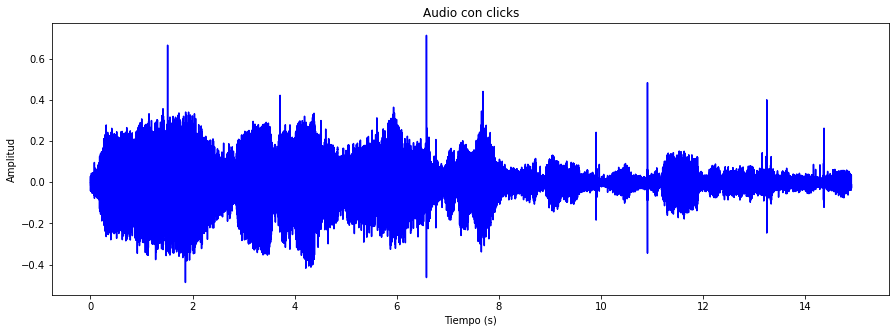

In [9]:
plot_audios([audio], 0, duracion_audio, titulo="Audio con clicks", colores=["blue"])

<div align='justify'>
Observamos el espectro temporal de la señal de audio. Notamos como aparecen los clicks como deltas, algunos con mayor amplitud, es decir, que contienen mayor energía. <br> <br>
Como un primer análisis visual, se ve un click de importante amplitud cercano a los 6.5 segundos. Haremos un zoom en esa zona.
</div>

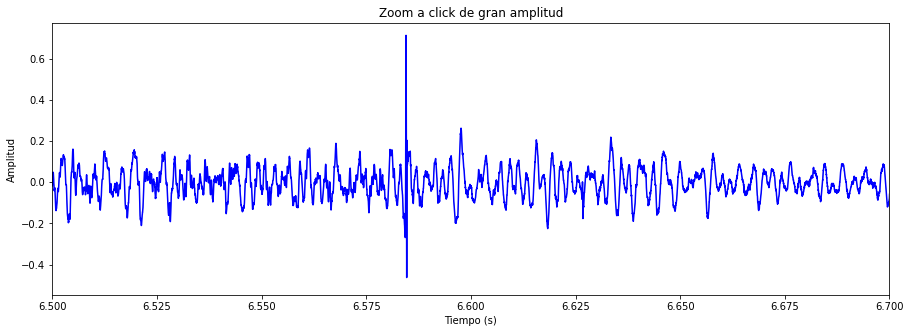

In [10]:
ax = plot_audios([audio], 0, duracion_audio, titulo="Zoom a click de gran amplitud", colores=["blue"], get_axes=True)
ax.set_xlim(6.5,6.7)
plt.show()

<div align='justify'>
Escuchamos el audio completo y luego solo la porción desde los 6 hasta los 7 segundos.
</div>

In [11]:
ipd.Audio(audio, rate=44100)

In [12]:
ipd.Audio(audio[6*Fs:7*Fs], rate=44100)

#### ESPECTROGRAMA

El espectrograma es una herramienta que permite evaluar la evolución del espectro de una señal en el tiempo. Se realizan una serie de Transformadas de Fourier por tramos (FFT), donde cada tramo es "ventaneado", es decir, recortado de manera particular, y los espectros de cada tramo son analizados en un gráfico de frecuencias, tiempo y energía. Por ello, el espectrograma es muy útil para analizar fenómenos no estacionarios en los que hay cambios rápidos de energía del contenido espectral. <br> 

En nuestro caso es muy útil ya que los clicks aparecen de manera repentina en el tiempo, alterando las componentes de energía de frecuencia que se observarán en el espectro. <br> <br> 

Existen distintas relaciones de compromiso a tener en cuenta para realizar el espectrograma: 
- Tipo de ventana (<b>window</b>): Su espectro tendrá una determinada relación de alturas entre el lóbulo principal y los lóbulos secundarios <br> 
- Ancho de ventana o intervalo total de muestras (<b>nperseg</b>): Mientras mayor sea la ventana, menor será el lóbulo principal en frecuencia y mayor su precisión a la hora de convolucionar. <br> 
- Porcentaje de overlapping o intervalo de overlapping (<b>noverlap</b>): El overlapping consiste en desplazar la ventana y luego solapar para asegurar que no se poduzcan discontinuidades entre intervalos de ventaneo. <br> <br> 

Tanto el tipo de ventana como su ancho nos permiten mejorar la resolución frecuencial. Por su parte, el overlapping mejora la resolución temporal. <br>
Todos estos parametros se relacionan con la cantidad FFTs que se realizan, lo cual puede llegar a ser costoso desde un punto de vista temporal y de memoria. Dependiendo la aplicación, esto puede implicar una limitación. En este caso no presenta una limitación, por lo tanto, no se considera.

Se analizan 2 espectrogramas de la señal de audio. En cada uno se intenta obtener diferente información. <br>
En primer lugar, se utilizan los siguientes parametros
- Ventana: (tukey, 0.2), representa una "rectangular" con un porcentaje de suavizado
- Ancho de ventana: 3308, 75ms 
- Overlap: 2205 (66%)

In [13]:
f1, t1, Sxx1 = signal.spectrogram(audio, fs=sample_freq, window=('tukey', 0.2), nperseg=3308, noverlap=2205, scaling='spectrum')

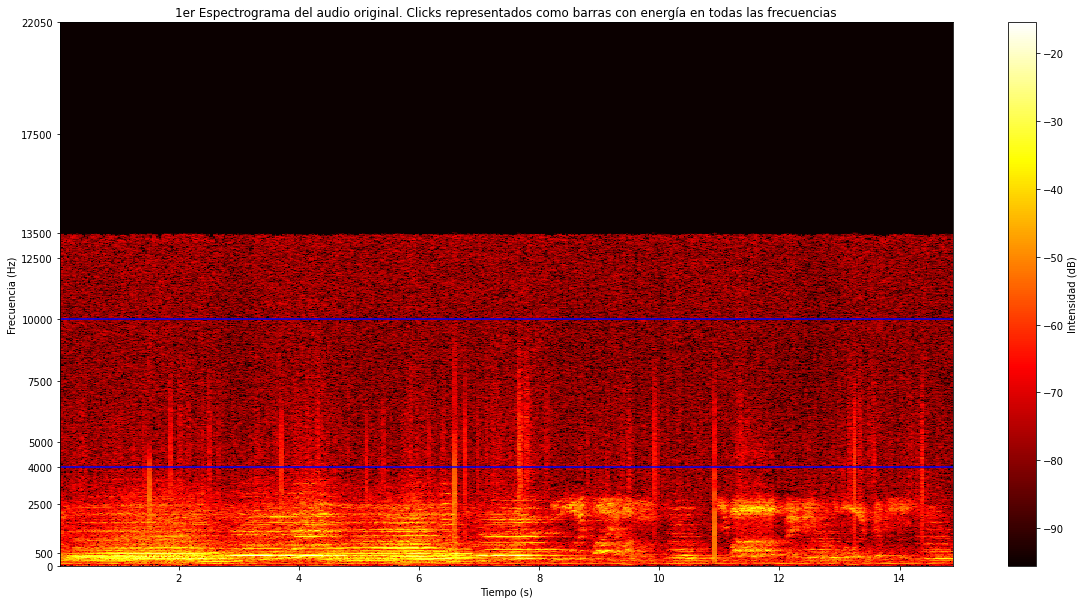

In [14]:
# Plot spectrogram
ax = plot_spectrogram(f1,t1,Sxx1,"1er Espectrograma del audio original. Clicks representados como barras con energía en todas las frecuencias","hot")
ax.axhline(10000, color="blue")
ax.axhline(4000, color="blue")
ax.set_yticks([0,500,2.5e3,4e3,5e3,7.5e3,10e3,12.5e3,13.5e3,17.5e3,22.05e3])
plt.show()

<br></br>
En segundo lugar, se utilizan los siguientes parámetros
- Ventana: tukey, 1 (representa una "hanning")
- Ancho de ventana: 12000 (272ms)
- Overlap: 4000 (67%)


In [15]:
f2, t2, Sxx2 = signal.spectrogram(audio, fs=sample_freq, window=('tukey', 1), nperseg=12000, noverlap=4000, scaling='spectrum')

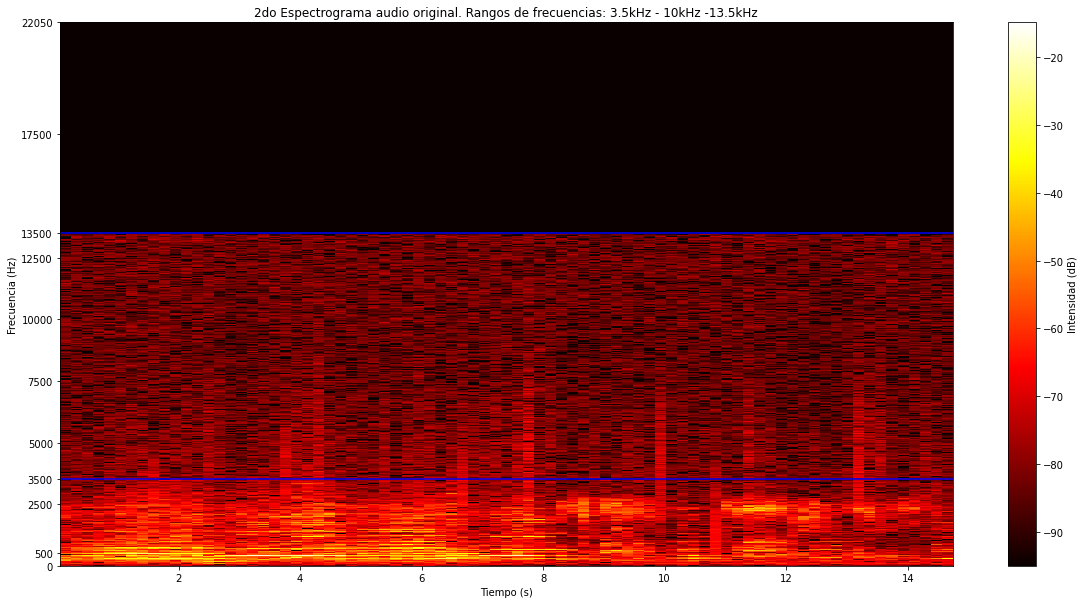

In [16]:
# Plot spectrogram
ax = plot_spectrogram(f2,t2,Sxx2,"2do Espectrograma audio original. Rangos de frecuencias: 3.5kHz - 10kHz -13.5kHz","hot")
ax.axhline(13500, color="blue")
ax.axhline(3500, color="blue")
ax.set_yticks([0,500,2.5e3,3.5e3,5e3,7.5e3,10e3,12.5e3,13.5e3,17.5e3,22.05e3])
plt.show()

En el primer espectrograma se observa con mayor claridad los clicks, esto se debe a que al realizar ventaneos de 75ms, se captura mejor el cambio repentino en tiempo. Sin embargo, se pierde presición frecuencial. A su vez, se opta por una ventana "rectangular suavizada" para obtener una buena información del tiempo sin generar grandes discontinuidades. <br> <br>

En el segundo espectrograma ya se dejan de apreciar los click de manera definida. Se ha perdido precisión en el tiempo por la elección de una ventana casi 4 veces más grande que en el primer caso, 272ms. Sin embargo, se ha obtenido una mejor representación de las diferencias relativas de energía entre las componentes que forman parte de la música y todo aquello que puede ser considerado como degradación del sonido. Se utiliza una ventana que representa una "hanning" para tener mejor representación espectral. <br> 

A partir de ambos espectrogramos se puede extraer la siguiente informacion:
- Casi toda la energía de la música llega hasta los 3500-4000 Hz
- Los clicks tienen una frecuencia máxima que oscila entre los 4000-10000 Hz
- Todo el sonido llega hasta los 13500 Hz
- A partir de los 13500 Hz y hasta los 22050Hz ninguna componente de frecuencias tiene energía

A continuación una tabla que resume los parámetros utilizados:

| Parámetro | Valor 1   | Valor 2   |
| :---:     | :---:    | :---:    |
| Ancho ventana  | 75ms  | 272ms |
| Largo de las FFTs  | 3308  | 12000 |
| Overlapping  | 67 % | 67 % |
| Cantidad de FFTs realizadas | 332 FFTs | 92 FFTs | 

De manera general, se observan 2 tipos de <b>degradaciones</b> del sonido: <b>globalizadas</b> y <b>localizadas</b>. <br>
Las degradaciones globalizadas son aquellas que afectan varias muestras de la señal, demuestran la presencia de ruido de fondo ("white noise") que caracteriza por el hecho de que sus valores de señal en dos tiempos diferentes no guardan correlación estadística, es aleatiorio, como consecuencia de ello, su densidad espectral de potencia es una constante, su gráfica es plana. <br>
Por su parte, las degradaciones localizadas solo afectan pocas muestras, son los denominados "<b>clicks</b>" o "frituras", que se caracterizan por su aparición repentina en el tiempo, "deltas" temporales y por contener energía en todas las frecuencias. <b>En el espectrograma se observan como "barras" verticales</b>, con determinada duración en tiempo, y con energía máxima de 10kHz aproximadamente.

La frecuencia máxima de la señal es aproximadamente 13.5kHz, se observa en el espectrograma que a partir de esta frecuencia, no hay densidad de energía espectral alguna. Esto nos indica que la señal originalmente fue muestreada a aproximadamente 27kHz. <br> Antes de ser muestreada probablemente fue filtrada con un pasabajos, eliminando toda frecuencia superior a los 13.5kHz para evitar aliasing, y ello, explica porque existe una franja "oscura" de nula energía en altas frecuencias.

# 2. Detección de Clicks

Para realizar la detección automática de clicks se diseña e implementa un filtro pasaaltos. El filtro realzará frecuencias superiores a una frecuencia de corte impuesta y atenuará todas las frecuencias inferiores. La elección de la frecuencia de corte está relacionada con la frecuencia máxima a la que llega la música.
Luego de filtrar la señal se observará como la amplitud de los clicks se acentúa en relación al resto del audio, haciendo más eficaz la detección de los mismos. <br> <br>

Existen dos tipos de filtros digitales: IIR (Infinite Impulse Response) o FIR (Finite Impulse Response). La ventaja que tiene el FIR es que se puede obtener una fase lineal de forma exacta. En cambio con el IIR solo se puede lograr una aproximación. Es muy importante mantener la fase lineal para que implique solo un desplazamiento temporal del audio. <br>
Los FIR son siempre estables por su estructura no recursiva. <br>
Por otro lado, para implementar el filtro IIR se necesita conocer la respuesta al impulso para todo tiempo (infinitos valores). <br>
Por estos dos motivos, se <b>opta por utilizar un filtro FIR.</b> <br> <br>

La respuesta en frecuencia del filtro es un <b>PASAALTOS</b> de <b>FASE LINEAL</b>. <br>
Se pueden tener una serie de especificaiones para su diseño como: frecuencia de atenuación, frecuencia de paso, banda de transición, ripple en la banda de atenuación y ripple en la banda de paso. <br>
En principio se tiene en cuenta la frecuencia de corte: 4500 Hz. <br> <br>

La respuesta impulsiva del filtro es una sinc desplazada en el tiempo. La misma posee un lóbulo principal y lóbulos secundarios, los cuales pueden generar varios clicks muy cercanos a partir de lo que originalmente era un solo click. Por ello es importante mitigar esto mediante una función que "junte" clicks que se encuentren a una distancia menor que cierto parámetro y pasen a ser considerados como un solo click de mayor tamaño. Este parámetro inicialmente sera la duración del click más largo. <br> <br>

Ambos puntos anteriores se relacionan con el orden del filtro ya que hay relaciones de compromiso a tener en cuenta:  Mientras mayor sea el orden, menor será la banda de transción, es decir, una frecuencia de corte de mayor presición. Un mayor orden también significa un mayor costo computacional a la hora de convolucionar la señal de audio. <br>
Para está aplicación no existe un límite estricto de costo computacional, a su vez, tampoco es determinante tener una banda de transición muy estrecha, ya que los clicks presentan bandas de frecuencias que llegan a los 5kHz en algunos casos, y hasta los 10kHz en otros. Esto se observa en los espectrogramas del inicio. <br>
En principio, se utiliza un <b>orden de 51</b>. <br>

Para el diseño del filtro se utiliza el <b>Método de Ventaneo</b>, el cual consiste en mulitplicar a la respuesta (infinita) al impulso del filtro por una ventana de 2N (N:orden del filtro). <br>
De nuevo, existen distintas ventanas: 
- Con una ventana rectangular aparecen muchos lóbulos secundarios de la sinc lo que en el espectro se manifiesta como ripple.
- Con una ventana hanning se atenúan dichos lóbulos secundarios y el consecuente ripple.
La eleccion de la ventana viene dado por el compromiso entre ancho del lóbulo principal, y la altura de los lóbulos secundarios.

Definción de la función que crea la respuesta al impulso del filtro pasa-altos:

In [17]:
def h_HP(fc, order, alpha=1, Fs=44.1e3):
    
    if(order%2==0):
        order += 1
        
    h = np.zeros(order)

    inicio = -(order-1)/2
    fin = (order-1)/2
    muestras = order
        
    n = np.linspace(inicio, fin, muestras) 
    
    f_A = Fs/2 - fc
    
    amplitud = 2 * f_A / Fs
        
    h = amplitud * np.sinc(2 * f_A / Fs * n) * np.power(-1,n)
    h *= signal.windows.tukey(order,alpha=alpha)
    
    return h

In [56]:
fc = 4.5e3
orden = 51
ventana = 1

hn = h_HP(fc,orden,alpha=ventana,Fs=Fs)

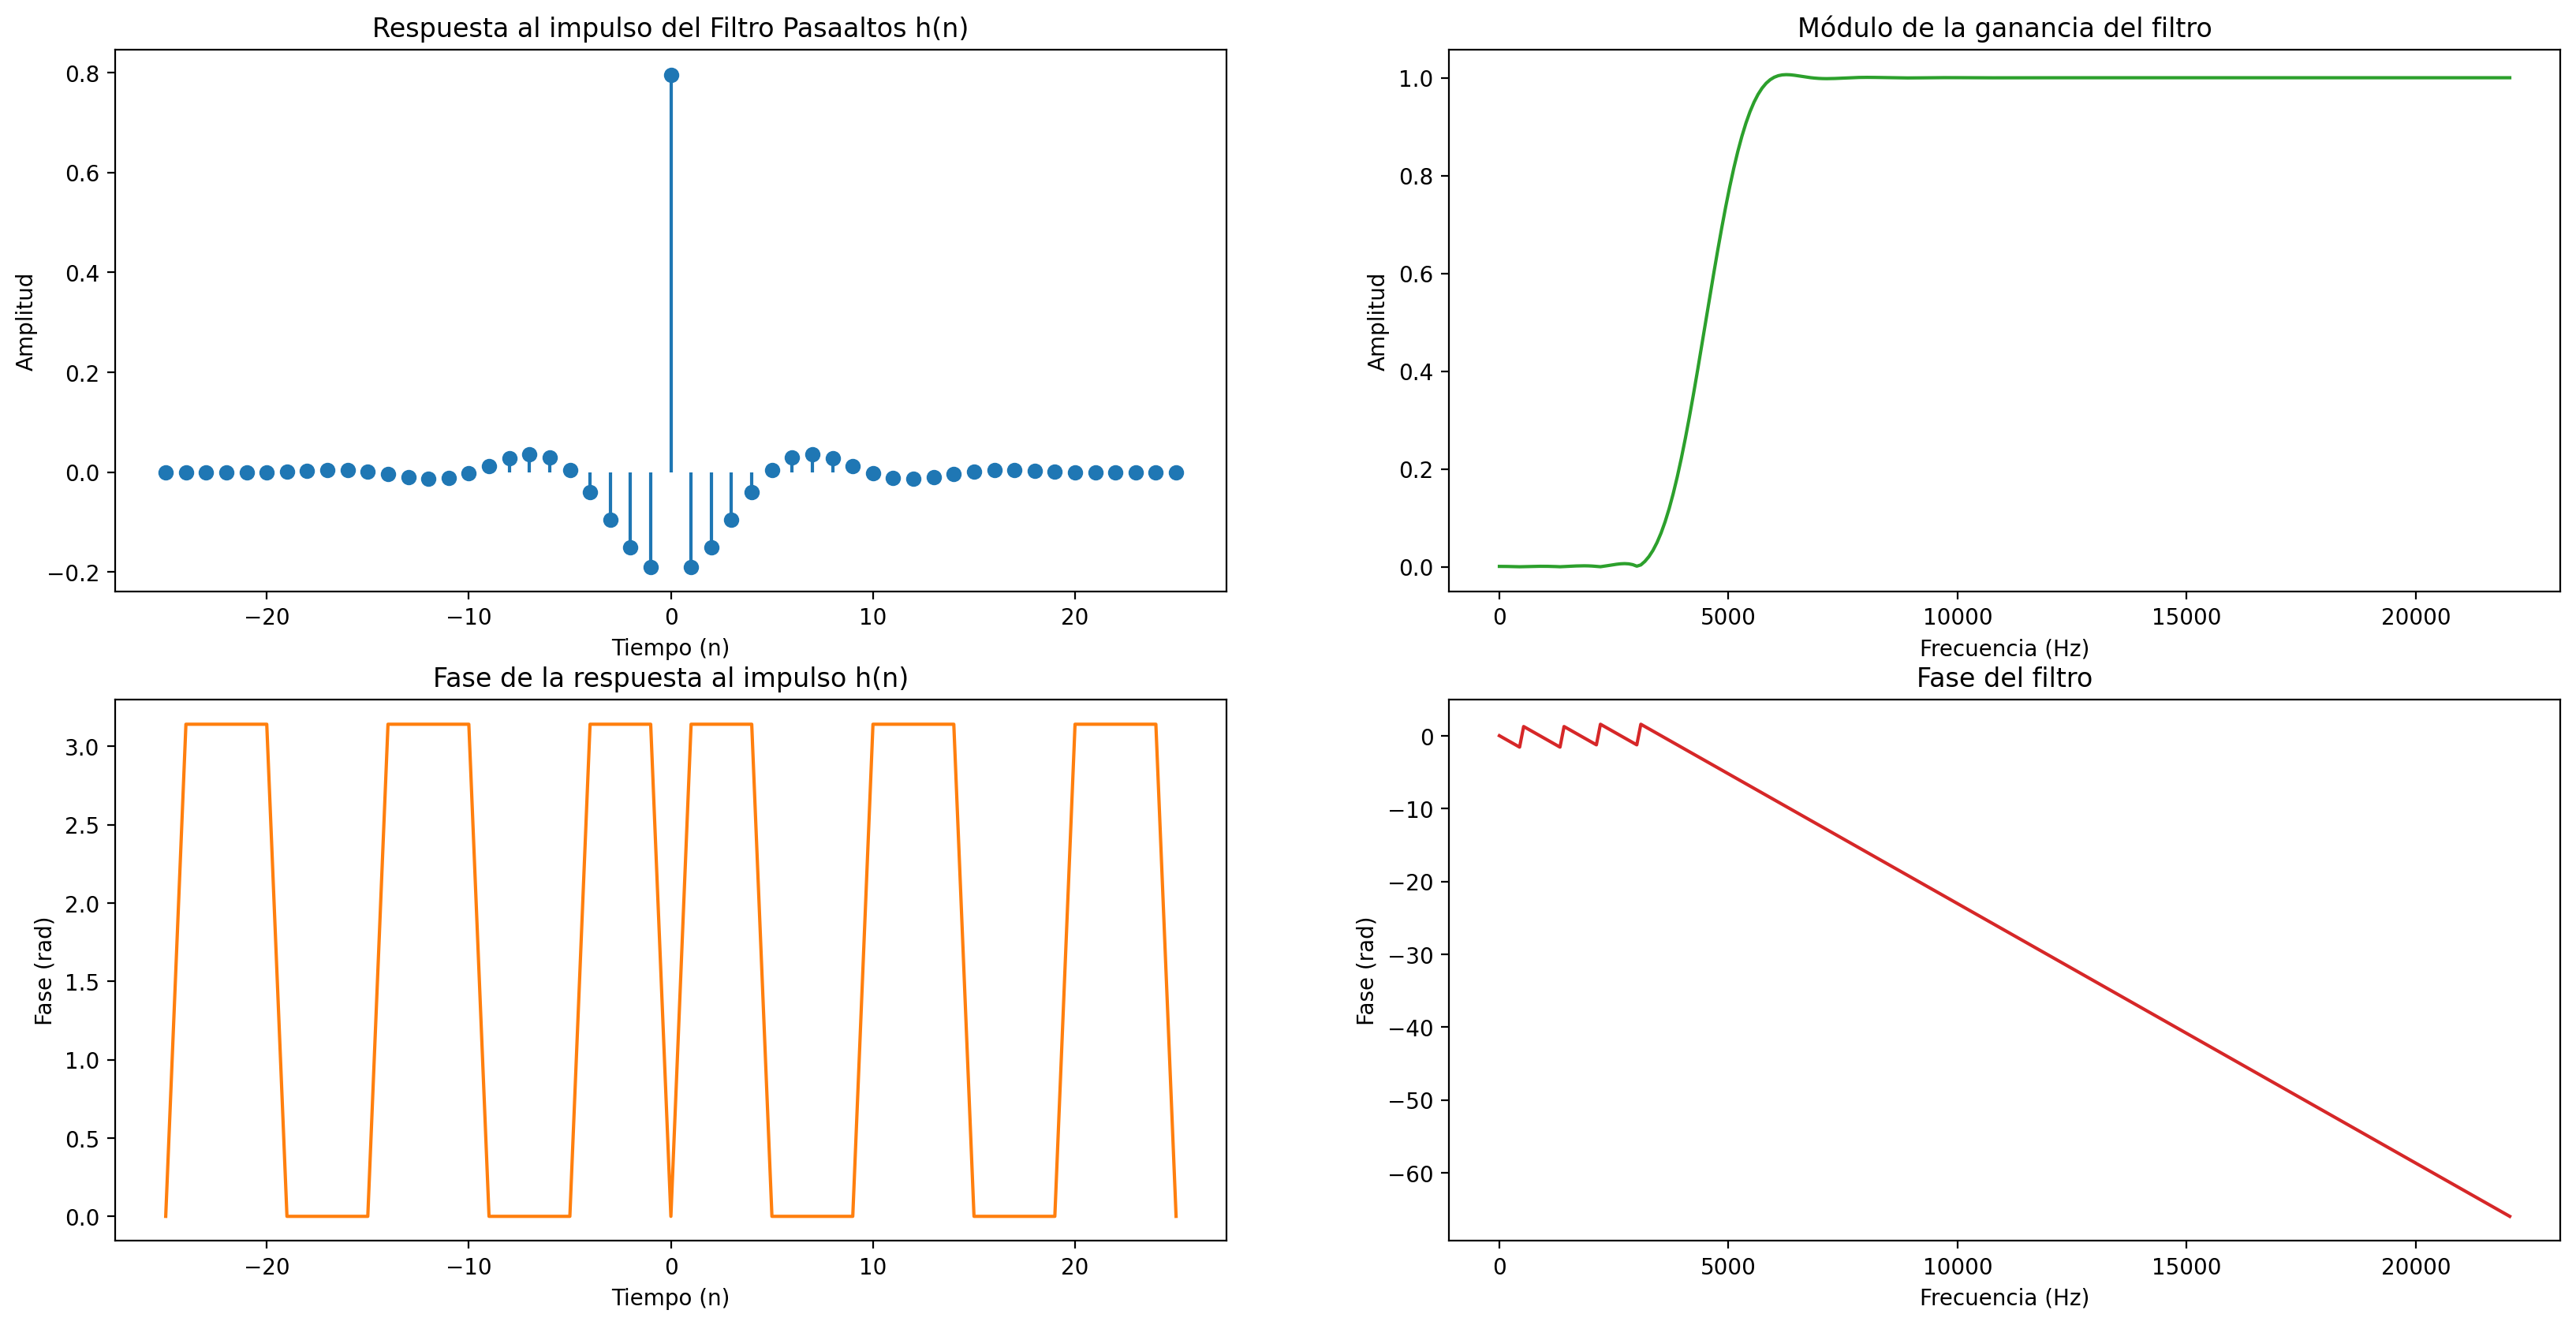

In [81]:
ax = plot_filtro(hn,orden,tipo='todo')
# ax.axvline(3000)

In [20]:
audio_filtrado = filtrar_audio(audio, hn)

#### Gráfico audio original vs audio filtrado

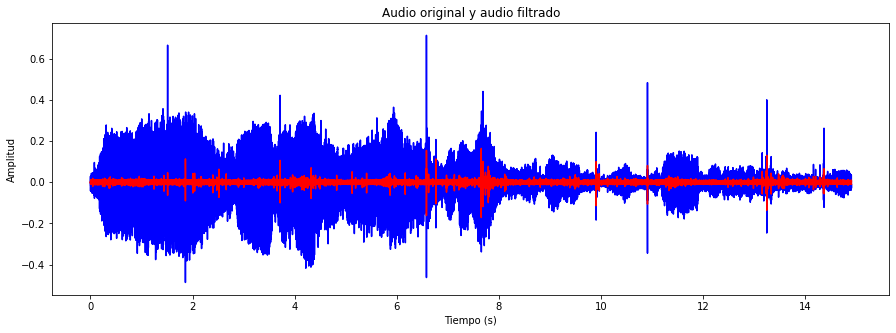

In [21]:
plot_audios([audio, audio_filtrado], 0, duracion_audio, titulo="Audio original y audio filtrado", colores=["blue", "red"])

#### Establezco umbral. Grafico audio filtrado y umbral

In [22]:
umbral = 0.032

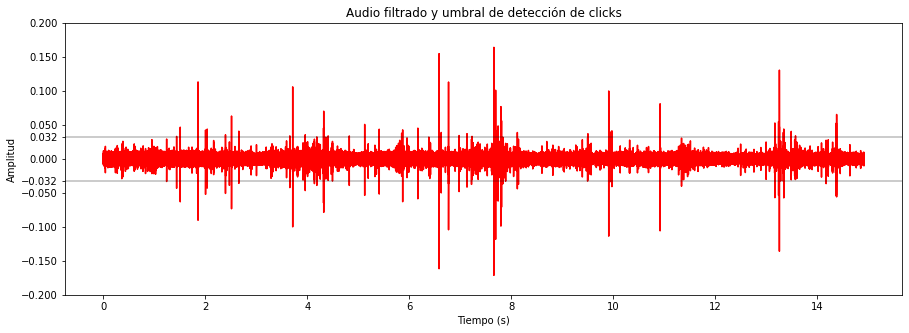

In [23]:
ax = plot_audios([audio_filtrado], titulo='Audio filtrado y umbral de detección de clicks', colores=['red'], get_axes=True)
ax.axhline(umbral, color='black', linewidth=0.4)
ax.axhline(-umbral, color='black', linewidth=0.4)
ax.set_yticks(list(ax.get_yticks()) + [-umbral, umbral])
plt.show()

A partir del gráfico anterior se puede definir un umbral de amplitud a partir del cual se identificará a la porción de señal como un click. <br>
La función <b>find_clicks</b> realiza esta tarea

In [24]:
clicks = find_clicks(audio_filtrado, umbral)

El vector <b>clicks</b> contiene información sobre la posición (número de muestra) y el tamaño (cantidad de muestras afectadas) de cada click.

In [25]:
max_click = find_max_click(clicks)

Vemos la posición y el tamaño del click más largo:

In [26]:
max_click

(290382, 10)

#### REDEFINO CLICKS

Ocurre que hay muchos clicks que se encuentren a una distancia muy próxima, y por lo tanto, deben ser considerados como un único click. <br>
Para ello, se redefinen los clicks a través de la función <b> join_clicks </b> y lo gurado en el vector <b>joined_clicks</b>. <br>
Se utiliza como parámetro de cercanía mínima el largo del <b>max_click</b>

In [27]:
joined_clicks = join_clicks(clicks,max_click[1])

In [28]:
max_joined_click = find_max_click(joined_clicks)

In [82]:
len(joined_clicks)

70

Ahora la posición y el tamaño del click más largo:

In [29]:
max_joined_click

(290367, 29)

Gráfico del intervalo del click más largo, el audio original y el audio filtrado. Además del umbral utilizado.

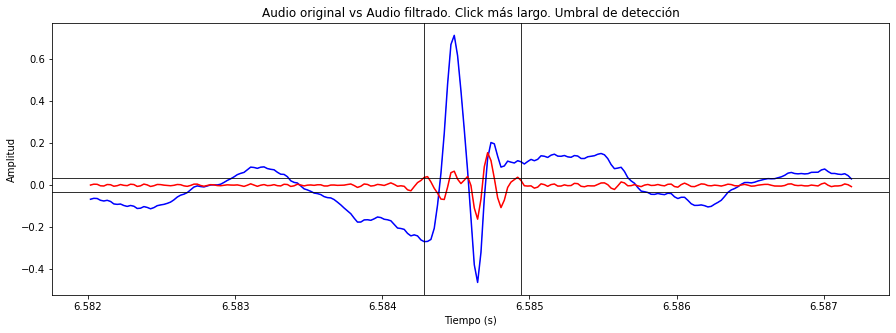

In [30]:
comienzo_click = max_joined_click[0]
fin_click = max_joined_click[0] + max_joined_click[1]

muestra_ini = comienzo_click - 100
muestra_fin = fin_click + 100

ax = plot_audios([audio, audio_filtrado], inicio=muestra_ini, fin=muestra_fin, titulo="Audio original vs Audio filtrado. Click más largo. Umbral de detección", colores=['blue','red'], get_axes=True)
ax.axvline(comienzo_click/Fs, color='black', linewidth=0.8)
ax.axvline(fin_click/Fs, color='black', linewidth=0.8)
ax.axhline(umbral, color='black', linewidth=0.8)
ax.axhline(-umbral, color='black', linewidth=0.8)
plt.show()

Vemos que la señal original tenía lo que parece un click más importante y otro secundario. <br>
Luego de filtrarlo con la sinc aparecen clicks "secundarios" que provienen de los lóbulos secundarios de la sinc. Según el umbral utilizado pueden llegar a ser detectados como nuevos clicks. <br>
De ahi la importancia de unir clicks y considerarlos como uno solo. <br>

# 3. Reemplazo de la señal deteriorada

#### Búsqueda del Reemplazo

Se realiza un proceso de búsqueda del reemplazo para las secciones degradadas de la señal que consiste en el siguiente método:
- Se define una sección de señal de NP puntos que rodee la parte donde aparece el click, esta sección será la <b>plantilla</b>
- Se define una ventana de búsqueda con los NW puntos inmediatamente anteriores al comienzo de la plantilla, será la <b>ventana</b> <br>
- Se compara la plantilla contra cada cada porción de puntos de la misma longitud dentro de la ventana, utilizando la <b>cross correlación</b> entre ambas, como medida de similitud. 
- Se retiene la sección con mayor similitud
- Se realiza el mismo proceso pero con una ventana que incluya los NW puntos inmediatamente posteriores.
- Se calcula el promedio de los anteriores, y se guarda: el promedio y su posición en el audio, en un vector de plantillas
<br> <br>
Para el ancho de la plantilla: <b>NP</b>, considero 4 veces el tamaño del click más largo. <br>
Para el ancho de la ventana: <b>NW</b>, considero el doble del ancho de la plantilla. <br>

In [31]:
NP = max_joined_click[1] * 4
NW = NP * 2

Vemos en el siguiente gráfico el intervalo del click más largo, el ancho de la plantilla y el ancho de la ventana

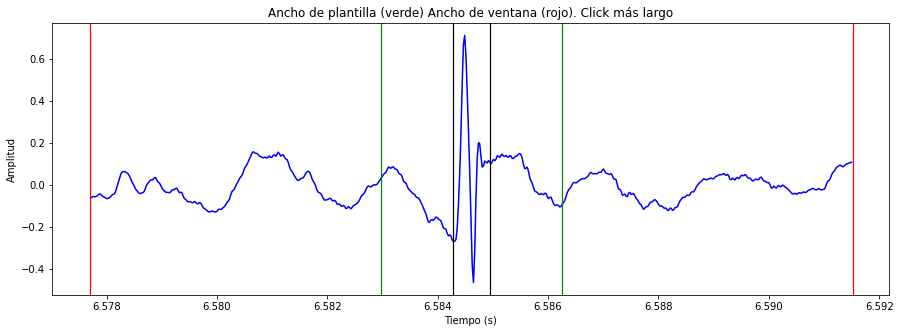

In [32]:
comienzo_click = max_joined_click[0]
fin_click = max_joined_click[0] + max_joined_click[1]

inicio_plantilla = comienzo_click - NP//2
fin_plantilla = fin_click + NP //2

inicio_ventana = inicio_plantilla - NW
fin_ventana = fin_plantilla + NW

ax = plot_audios([audio], inicio=inicio_ventana, fin=fin_ventana, titulo="Ancho de plantilla (verde) Ancho de ventana (rojo). Click más largo", colores=['blue'], get_axes=True)
ax.axvline(comienzo_click/Fs, color='black', linewidth=1.2)
ax.axvline(fin_click/Fs, color='black', linewidth=1.2)

ax.axvline(inicio_plantilla/Fs, color='green', linewidth=1.2)
ax.axvline(fin_plantilla/Fs, color='green', linewidth=1.2)

ax.axvline(inicio_ventana/Fs, color='red', linewidth=1.2)
ax.axvline(fin_ventana/Fs, color='red', linewidth=1.2)

# ax.axhline(umbral, color='black', linewidth=0.8)
# ax.axhline(-umbral, color='black', linewidth=0.8)
plt.show()

A continuación la función <b>audio_cross_correlate_clicks</b> <br>
Que recorre el audio en las posiciones de los clicks, y va comparando porciones del audio (de tamaño NP sumado al largo del click) con las muestras de una "ventana adelante" y una "ventana atras". Calcula la <b>correlación</b> con cada ventana y luego se queda con el promedio de ambas. <br>
Devuelve un vector con las plantillas correlacionadas y sus posiciones de inicio, que luego deberán ser correctamente empalmadas en el audio.

In [33]:
# recibe el audio, los clicks (posiciones), largo plantilla: NP, largo ventana: NW
# devuelve un vector de tamano NP que equivale al promedio entre las 2 mejores plantillas: 1 de la ventana posterior y una de la ventana anterior
def audio_cross_correlate_clicks(audio, clicks, NP, NW):
    
    # NP es el tamaño de la plantilla sin contar el click
    len_audio = len(audio)
    cant_clicks = len(clicks)
    
    # vector que contiene mejores correlaciones y sus posiciones en el audio
    vectores_correlation = []
                      
    for pos,tam in clicks:
        inicio_plantilla = pos-NP//2
        fin_plantilla = pos+tam+NP//2
        
        inicio_vent_ant = inicio_plantilla-NW
        fin_vent_post = fin_plantilla+NW
        
        if(inicio_vent_ant < 0): 
            inicio_vent_ant = 0
        if(fin_vent_post > len_audio): 
            fin_vent_post = len_audio
        
        # vectores
        audio_vent_ant = audio[inicio_vent_ant:inicio_plantilla]
        audio_plantilla = audio[inicio_plantilla:fin_plantilla]
        audio_vent_post = audio[fin_plantilla:fin_vent_post]
                
        # busco vector con mayor correlacion en ventana anterior y ventana posterior
        vector_max_corr_vent_ant = max_cross_correlation(audio_plantilla, audio_vent_ant)
        vector_max_corr_vent_post = max_cross_correlation(audio_plantilla, audio_vent_post)
        
        # calculo el promedio entre los vectores anteriores
        prom = promedio_vectores(vector_max_corr_vent_ant, vector_max_corr_vent_post)
        
        # agrego el promedio al vector con mejores correlacion y su posicion en audio
        vectores_correlation.append([inicio_plantilla, prom])  
        
    return vectores_correlation

In [34]:
plantillas_correlacionadas = audio_cross_correlate_clicks(audio, joined_clicks, NP, NW)

In [35]:
# busco indice para que coincidan
plantilla_max = plantillas_correlacionadas[27][1]
max_joined_click[0], plantillas_correlacionadas[27][0]

(290367, 290309)

#### Grafico el click más largo y la  plantilla "a empalmar"

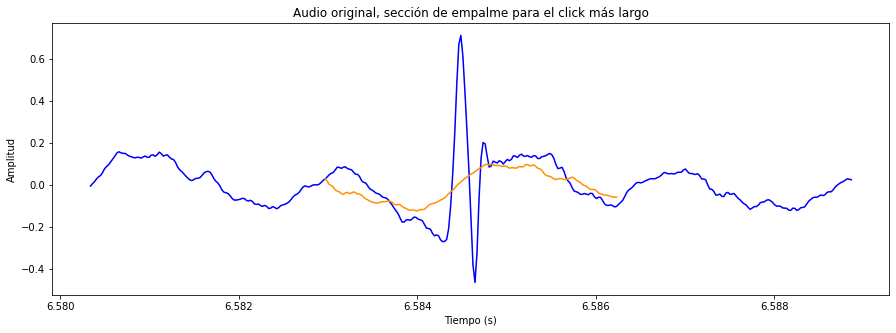

In [36]:
in_max_click = max_joined_click[0]
fin_max_click = max_joined_click[0] + max_joined_click[1]

in_vent = in_max_click - NP//2 - NW//2
fin_vent = fin_max_click + NP//2 + NW//2

in_plant = in_max_click - NP//2
fin_plant = fin_max_click + NP //2

x_axis = np.arange(in_plant,fin_plant,1)/Fs

ax = plot_audios([audio], inicio=in_vent, fin=fin_vent, titulo='Audio original, sección de empalme para el click más largo', colores=['blue'], get_axes=True)
ax.plot(x_axis,plantilla_max, color='#ff9100')
plt.show()

#### Reconstrucción / Empalme

Para realizar la reconstrucción de la señal se realiza un empalme suave con el objetivo de no generar nuevas discontinuidades. <br>
Para esto se utiliza la función <b>empalmar_audio</b>, la cual recorre el audio y reemplaza las porciones de audio con clicks por las plantillas calculadas anteriormente mediante un promedio ponderado que asigna mayor peso a la señal original en los extremos de la sección y mayor peso a la plantilla en el medio. <br>
Este promedio se realiza con un vector con valores provenientes de la ventana tukey. Vemos graficados los pesos de este vector en el Anexo junto con una justificación de su elección.

In [37]:
def empalmar_audio(audio, plantillas, NP, NW):
    
    audio_empalmado = np.copy(audio)
    len_audio = len(audio)
    
    # vector que contiene mejores correlaciones y sus posiciones en el audio
    vectores_correlation = []
                      
    for pos,plantilla in plantillas:
        
        tam_plantilla = len(plantilla)
        inicio_plantilla = pos
        fin_plantilla = inicio_plantilla+tam_plantilla
        
        audio_porcion = audio[inicio_plantilla:fin_plantilla]
        
        # VENTANA UTILIZADA
        tukey_window = signal.windows.tukey(tam_plantilla,alpha=0.9)
        
        # OTRA POSIBLE VENTANA
        w_i=np.ones(tam_plantilla)
        w = np.pad(w_i, (tam_plantilla//3, tam_plantilla//3),mode='linear_ramp', end_values=(0.1, 0.1))
        
        pesos = tukey_window
        audio_nueva_porcion = empalmar_vectores(plantilla, audio_porcion, pesos) 
       
        audio_empalmado[inicio_plantilla:fin_plantilla] = audio_nueva_porcion
        
    return audio_empalmado

Realizo el empalme del audio a partir del vector con correlaciones: <b>plantillas_correlacionadas</b>

In [38]:
audio_empalmado = empalmar_audio(audio, plantillas_correlacionadas, NP, NW)

#### Grafico audio original vs audio empalmado para el click más largo

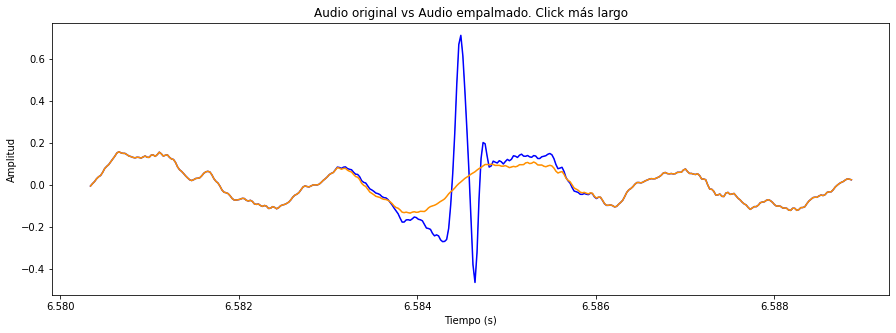

In [39]:
plot_audios([audio, audio_empalmado], inicio=in_vent, fin=fin_vent, titulo='Audio original vs Audio empalmado. Click más largo', colores=['blue','#ff9100'])

Finalmente, observamos el espectrograma y escuchamos el audio "empalmado".

In [40]:
ipd.Audio(audio_empalmado, rate=44100)

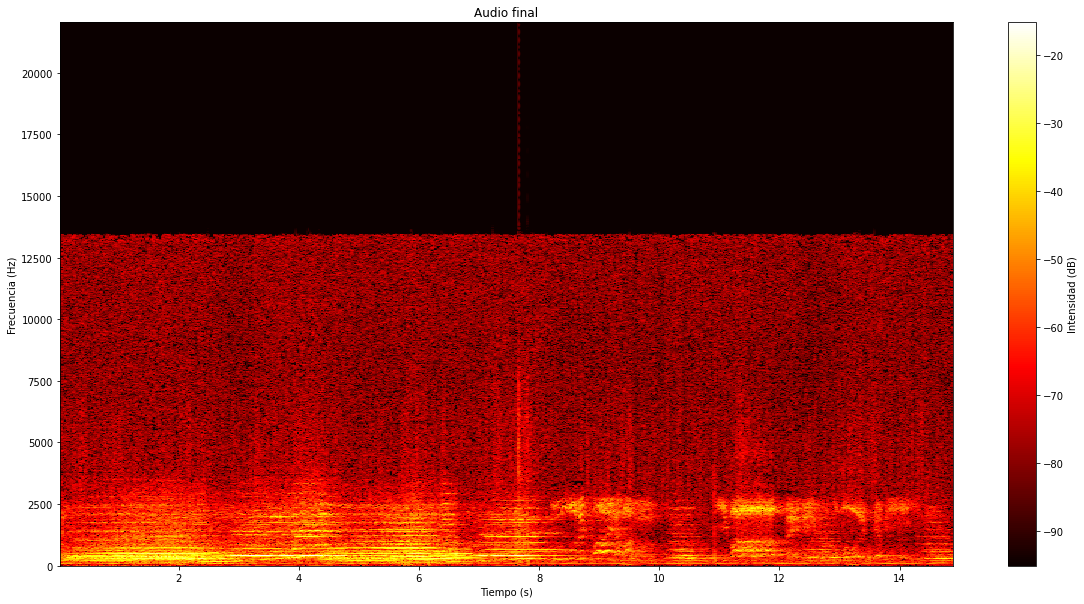

In [41]:
f_empal, t_empal, Sxx_empal = signal.spectrogram(audio_empalmado, fs=sample_freq, window=('tukey', 0.5), nperseg=3308, noverlap=2205, scaling='spectrum')

plot_spectrogram(f_empal,t_empal,Sxx_empal,"Audio final","hot")
plt.show()

A partir del espectrograma, concluimos que los clicks han sido atenuados notablemente. <br>
Siguen existiendo clicks, aunque con menor energía, y otro tipo de degradaciones como el ruido de fondo. Se podría mejorar más la calidad del audio a partir de otro tipo de técnicas de procesamiento.

#### Otro Método de reemplazo

Otro método a utilizarse sería que al momento de calcular la correlación no se tenga en cuenta la sección del click, es decir, realizar la comparación únicamente con la señal que rodea inmediatamente al click. A su vez, la ventana donde se realice dicha correlación debe haber pasado por un proceso previo donde se le hayan eliminado todos lo posibles clicks que allí se encuentren. El Objetivo principal de este método es de comparar porciones de audio que no se encuentren degradadas. <br>
Cabe destacar que para eliminar (filtrar) posibles clicks de las ventanas se requiere un preprocesamiento que puede aumentar la complejidad considerablemente.

# Anexo

#### Ventanas utilizadas, en tiempo y espectros

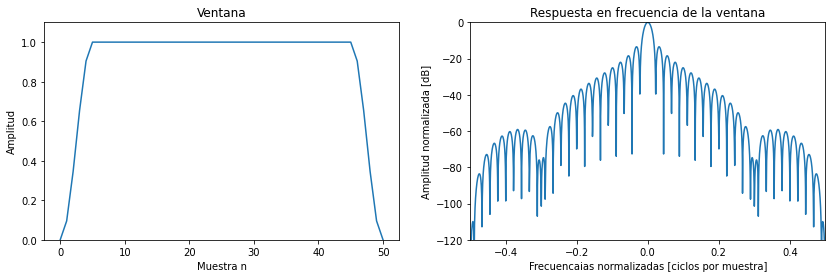

In [60]:
tukey_window = signal.windows.tukey(orden,alpha=0.2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.plot(tukey_window)
ax1.set_title("Ventana")
ax1.set_ylabel("Amplitud")
ax1.set_xlabel("Muestra n")
ax1.set_ylim([0, 1.1])

A = fft(tukey_window, 2048) / (len(tukey_window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs((fftshift(A / abs(A).max() ) + 1e-14)))
ax2.plot(freq, response)
ax2.axis([-0.5, 0.5, -120, 0])
ax2.set_title("Respuesta en frecuencia de la ventana")
ax2.set_ylabel("Amplitud normalizada [dB]")
ax2.set_xlabel("Frecuencaias normalizadas [ciclos por muestra]")
plt.show()

#### Para realizar el empalme
se utiliza una ventana 'tukey' de parámetro alpha=0.9. Se eligió la misma ya que presenta una transición suave entre la porción que vale 1 y la que vale 0, y presenta una sección que vale 1 de aproximadamente 1/5 del largo total. Como se vio antes la plantilla de mayor tamaño tiene 4 veces el largo del click. De aquí porque se eligió esta relación.  

Se grafica la ventana y su inversa

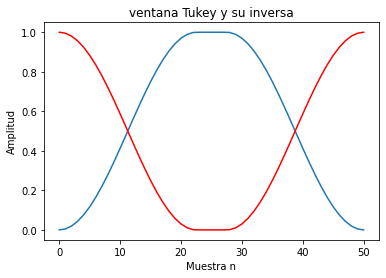

In [43]:
tukey_window = signal.windows.tukey(orden,alpha=0.9)
inversa = np.ones(orden) - tukey_window
plt.plot(tukey_window)

plt.plot(inversa, color="red")
plt.title("ventana Tukey y su inversa")
plt.ylabel("Amplitud")
plt.xlabel("Muestra n")
plt.show()

In [43]:
# Descargar Audio Final
# wavfile.write('audio_final.wav', Fs, audio_empalmado)